In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn import linear_model, decomposition, datasets
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [2]:
#retrieving the data
parkingdata = pd.read_csv("parking_duration_of_parking_event_vs_street_ID.csv")
parkingdata = parkingdata.sample(n=10000)
parkingdata.size

130000

In [3]:
#Converting all the feature attributes to uppercase for uniformity

parkingdata['Area Name'] = parkingdata['Area Name'].str.upper()
parkingdata['Street Name'] = parkingdata['Street Name'].str.upper()
parkingdata['Between Street 1'] = parkingdata['Between Street 1'].str.upper()
parkingdata['Between Street 2'] = parkingdata['Between Street 2'].str.upper()
parkingdata['Street Marker'] = parkingdata['Street Marker'].str.upper()
parkingdata['Sign'] = parkingdata['Sign'].str.upper()

parkingdata.head(5)

,Area Name,Street Name,Between Street 1,Between Street 2,Side Of Street,Street Marker,Arrival Time,Departure Time,Duration of Parking Event (in seconds),Sign,In Violation?,Street ID,Device ID
1288235,CITY SQUARE,FLINDERS LANE,SWANSTON STREET,RUSSELL STREET,4,1765S,06/11/2011 04:00:49 AM,06/11/2011 04:04:56 AM,247,P10 M-SUN 0:00-23:59,0,669,1432
3361418,THE MAC,FRANKLIN STREET,ELIZABETH STREET,SWANSTON STREET,4,6525S,05/01/2012 10:58:34 AM,05/01/2012 11:15:30 AM,1016,1/2P MTR M-SAT 7:30-19:30,0,681,2883
12119639,COUNTY,LONSDALE STREET,KING STREET,WILLIAM STREET,4,3199S,27/09/2012 02:57:05 PM,27/09/2012 03:29:07 PM,1922,1/2P MTR M-F 9:30-19:30,0,894,1781
5982687,SOUTHBANK,MILES STREET,STURT STREET,DODDS STREET,3,9512N,23/03/2012 02:40:23 PM,23/03/2012 02:41:27 PM,64,2P TKT A RPA M-F 7:30-18:30,0,1007,4457
6054987,QUEENSBERRY,LEVESON STREET,QUEENSBERRY STREET,VICTORIA STREET,1,C6388,26/03/2012 12:18:44 PM,26/03/2012 01:07:16 PM,2912,4P MTR M-F 7:30-18:30,0,881,3576


In [4]:
#Removing all redundant extra whitespaces
for x in parkingdata.columns:
    if parkingdata[x].dtype == object:
        parkingdata[x] = parkingdata[x].str.strip()

In [5]:
#converting object to datetime
parkingdata['Arrival Time'] = pd.to_datetime(parkingdata['Arrival Time'])
parkingdata['Departure Time'] = pd.to_datetime(parkingdata['Departure Time'])

In [6]:
#Target field identification
target = parkingdata['In Violation?']
target.head(10)

1288235     0
3361418     0
12119639    0
5982687     0
6054987     0
9749698     1
2538984     0
11372738    0
5993769     0
1468118     0
Name: In Violation?, dtype: int64

In [7]:
#Preliminary Target Features identification (Pre-Hill Climbing)

#Convert possible targets to dtype = int
intDf = parkingdata.copy()
#Drop useless fields
intDf.drop('Arrival Time', axis = 1, inplace = True)
intDf.drop('Departure Time', axis = 1, inplace = True)
intDf.drop('Street Marker', axis = 1, inplace = True)
#Drop target field
intDf.drop('In Violation?', axis = 1, inplace = True)
#Drop already int fields (Will add back after)
intDf.drop('Side Of Street', axis = 1, inplace = True)
intDf.drop('Duration of Parking Event (in seconds)', axis = 1, inplace = True)
intDf.drop('Street ID', axis = 1, inplace = True)
intDf.drop('Device ID', axis = 1, inplace = True)

#Transform the remainder non-int fields' values to unique int identifiers
for column in intDf:
    unique_vals = intDf[column].unique()
    intDf[column].replace(to_replace = unique_vals, value = list(range(len(unique_vals))), inplace = True)

#Create dataframe for all the relevant features
features = intDf.copy()

#Add back int fields (If not the target field)
features['Side Of Street'] = parkingdata['Side Of Street']
features['Duration of Parking Event (in seconds)'] = parkingdata['Duration of Parking Event (in seconds)']
features['Street ID'] = parkingdata['Street ID']
features['Device ID'] = parkingdata['Device ID']
#Add back datetime features with only the meaningful subset of data
features['Arrival Hour'] = parkingdata['Arrival Time'].dt.hour
features['Departure Hour'] = parkingdata['Departure Time'].dt.hour

#Table view of features dataframe
features.head(10)

,Area Name,Street Name,Between Street 1,Between Street 2,Sign,Side Of Street,Duration of Parking Event (in seconds),Street ID,Device ID,Arrival Hour,Departure Hour
1288235,0,0,0,0,0,4,247,669,1432,4,4
3361418,1,1,1,1,1,4,1016,681,2883,10,11
12119639,2,2,2,2,2,4,1922,894,1781,14,15
5982687,3,3,3,3,3,3,64,1007,4457,14,14
6054987,4,4,4,4,4,1,2912,881,3576,12,13
9749698,0,5,5,5,1,2,22980,1221,511,10,16
2538984,5,2,6,6,5,1,286,894,2026,16,16
11372738,6,6,7,7,6,4,856,926,7115,12,12
5993769,4,7,2,2,7,4,7539,614,2723,18,20
1468118,7,8,8,8,5,3,1783,123,1403,17,18


In [8]:
#Parameter Tuning

#Define the parameters to tune and the values to tune to
params_randomforest = [
                { 
                   'n_estimators' : (10,20,30,50,70,90,100),
                    'criterion' : ('gini', 'entropy'),
                    'max_depth' : (3, 5, 7, 9, 10, 15),
                    'max_features' : ('auto', 'sqrt'),
                    'min_samples_split' : (2, 4, 6, 8, 10, 14, 16)
                    
                }
            ]

In [11]:
cv_method = RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats = 1, 
                                    random_state = 1)

gs_randomforest = GridSearchCV(RandomForestClassifier(), 
                      param_grid = params_randomforest, 
                      cv = cv_method,
                      verbose = True,
                      scoring = 'accuracy',
                      n_jobs = -1,
                      return_train_score = True)

In [12]:
#Fit the model with the dataset
bestModel = gs_randomforest.fit(features, target)

Fitting 5 folds for each of 1176 candidates, totalling 5880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5880 out of 5880 | elapsed:  4.6min finished


In [14]:
gs_randomforest.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 100}

In [15]:
#Find the best values for the  parameters of the model (Formatted output)
best_e = bestModel.best_estimator_.get_params()['n_estimators']
best_C = bestModel.best_estimator_.get_params()['criterion']
best_maxd =  bestModel.best_estimator_.get_params()['max_depth']
best_maxf =  bestModel.best_estimator_.get_params()['max_features']
best_mins =  bestModel.best_estimator_.get_params()['min_samples_split']

print('Best estimator:', best_e)
print('Best criterion:', best_C)
print('Best max depth:', best_maxd)
print('Best max features:', best_maxf)
print('Best min_samples_split:', best_mins)

Best estimator: 100
Best criterion: entropy
Best max depth: 15
Best max features: sqrt
Best min_samples_split: 2


In [16]:
#Visualise the parameter configurations from fitting the model with the dataset
results_randomforest = pd.DataFrame(gs_randomforest.cv_results_['params'])
results_randomforest['test_score'] = gs_randomforest.cv_results_['mean_test_score']
results_randomforest

,criterion,max_depth,max_features,min_samples_split,n_estimators,test_score
0,gini,3,auto,2,10,0.8912
1,gini,3,auto,2,20,0.8904
2,gini,3,auto,2,30,0.8851
3,gini,3,auto,2,50,0.8986
4,gini,3,auto,2,70,0.8853
...,...,...,...,...,...,...
1171,entropy,15,sqrt,16,30,0.9599
1172,entropy,15,sqrt,16,50,0.9596
1173,entropy,15,sqrt,16,70,0.9606
1174,entropy,15,sqrt,16,90,0.9604


In [17]:
#Re-Define model with the optimal parameter values AFTER HILL CLIMBING
randomforest = metric = RandomForestClassifier(n_estimators = best_e, 
                               criterion = best_C, 
                               max_depth = best_maxd, 
                               max_features = best_maxf,
                               min_samples_split = best_mins                
                               )

In [18]:
# Hill climbing w/ SVM
new_Ind = []
cur_MaxScore = 0.0
col_num = len(features.columns)
col_Ind_Random = shuffle(range(0, col_num), random_state = 1)
features_array = features.values

for cur_f in range(col_num):
    new_Ind.append(col_Ind_Random[cur_f])
    newData = features_array[:, new_Ind]
    x_train, x_test, y_train, y_test = train_test_split(newData, target, test_size=0.2, random_state=1)
    fit = randomforest.fit(x_train, y_train)
    cur_Score = randomforest.score(x_test, y_test)
    
    if cur_Score < cur_MaxScore:
        new_Ind.remove(col_Ind_Random[cur_f])
    else:
        cur_MaxScore = cur_Score
        print ("Score with " + str(len(new_Ind)) + " selected features: " + str(cur_Score))
print("\nIndexs of the desired features")
print(new_Ind)

Score with 1 selected features: 0.861
Score with 2 selected features: 0.862
Score with 3 selected features: 0.925
Score with 4 selected features: 0.9465
Score with 5 selected features: 0.95
Score with 6 selected features: 0.951
Score with 7 selected features: 0.954

Indexs of the desired features
[2, 3, 6, 0, 7, 8, 5]


In [19]:
features_hc = pd.DataFrame()
for index in new_Ind:
    colName = features.columns[index]
    features_hc[colName] = features[colName]
features_hc.head(10)

,Between Street 1,Between Street 2,Duration of Parking Event (in seconds),Area Name,Street ID,Device ID,Side Of Street
1288235,0,0,247,0,669,1432,4
3361418,1,1,1016,1,681,2883,4
12119639,2,2,1922,2,894,1781,4
5982687,3,3,64,3,1007,4457,3
6054987,4,4,2912,4,881,3576,1
9749698,5,5,22980,0,1221,511,2
2538984,6,6,286,5,894,2026,1
11372738,7,7,856,6,926,7115,4
5993769,2,2,7539,4,614,2723,4
1468118,8,8,1783,7,123,1403,3


In [20]:
bestModel = gs_randomforest.fit(features_hc, target)

Fitting 5 folds for each of 1176 candidates, totalling 5880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 1376 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 1826 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 2376 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3776 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 4626 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 5576 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 5880 out of 5880 | elapsed:  3.9min finished


In [21]:
gs_randomforest.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 100}

In [22]:
best_e_hc = bestModel.best_estimator_.get_params()['n_estimators']
best_C_hc = bestModel.best_estimator_.get_params()['criterion']
best_maxd_hc =  bestModel.best_estimator_.get_params()['max_depth']
best_maxf_hc =  bestModel.best_estimator_.get_params()['max_features']
best_mins_hc =  bestModel.best_estimator_.get_params()['min_samples_split']

print('Best estimators:', best_e_hc)
print('Best criterion:', best_C_hc)
print('Best max depth:', best_maxd_hc)
print('Best max features:', best_maxf_hc)
print('Best min_samples_split:', best_mins_hc)

Best estimators: 100
Best criterion: entropy
Best max depth: 15
Best max features: auto
Best min_samples_split: 2


In [23]:
#Visualise the parameter configurations from fitting the model with the dataset
results_randomforest = pd.DataFrame(gs_randomforest.cv_results_['params'])
results_randomforest['test_score'] = gs_randomforest.cv_results_['mean_test_score']
results_randomforest

,criterion,max_depth,max_features,min_samples_split,n_estimators,test_score
0,gini,3,auto,2,10,0.8864
1,gini,3,auto,2,20,0.8755
2,gini,3,auto,2,30,0.8788
3,gini,3,auto,2,50,0.8972
4,gini,3,auto,2,70,0.8788
...,...,...,...,...,...,...
1171,entropy,15,sqrt,16,30,0.9494
1172,entropy,15,sqrt,16,50,0.9488
1173,entropy,15,sqrt,16,70,0.9496
1174,entropy,15,sqrt,16,90,0.9498


In [24]:
randomforest = metric = RandomForestClassifier(n_estimators = best_e_hc, 
                               criterion = best_C_hc, 
                               max_depth = best_maxd_hc, 
                               max_features = best_maxf_hc,
                               min_samples_split = best_mins_hc                
                               )


 Accuracy score: 0.94680

 Misclassification Rate: 0.05320

 True Positive Rate: 0.74380

 True Negative Rate: 0.98128

 Precision : 0.87097

 Prevalence : 0.14520

 F score : 0.80238

 False Positive Rate: 0.01872


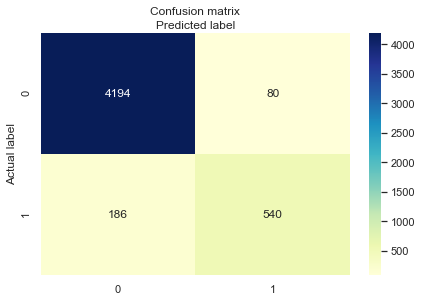

In [25]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
randomforest.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = randomforest.predict(x_test)
cm = metrics.confusion_matrix(y_test,predicted)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

#Printing the numerical result of the confusion matrix
print("\n Accuracy score: {:.5f}".format(randomforest.score(x_test, y_test)))
misclassification_error = (FP + FN) / float(TP + TN + FP + FN)
print("\n Misclassification Rate: {:.5f}".format(misclassification_error))
sensitivity = TP / float(FN + TP)
print("\n True Positive Rate: {:.5f}".format(sensitivity))
specificity = TN / (TN + FP)
print("\n True Negative Rate: {:.5f}".format(specificity))
precision = TP / float(TP + FP)
print("\n Precision : {:.5f}".format(precision))
prevalence =  float(FN + TP)/float(TP + TN + FP + FN)
print("\n Prevalence : {:.5f}".format(prevalence))
fscore = (2 * precision * sensitivity) / (precision + sensitivity)
print("\n F score : {:.5f}".format(fscore))
print("\n False Positive Rate: {:.5f}".format(1-specificity))

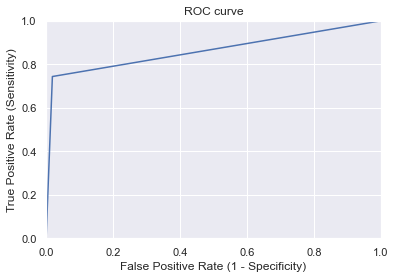

In [26]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,predicted)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [28]:
#Repeat with KFold - creating groups
kf = KFold(n_splits = 5, random_state = 4, shuffle = True)


#Repeat with KFold - Training model (previously defined) and obtaining its output
kFoldTotal = 0
for k, (train_index, test_index) in enumerate(kf.split(features_hc)):
    x_train, x_test = features_hc.iloc[train_index], features_hc.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    randomforest.fit(x_train, y_train)
    kFoldTotal += randomforest.score(x_test, y_test)
    print("[fold {0}] score: {1:.5f}".format(k, randomforest.score(x_test, y_test)))

#Printing out the results
roundedTotal = round(kFoldTotal/5, 5)
print("\nKNN mean score [5 folds] = " + str(roundedTotal))

[fold 0] score: 0.95350
[fold 1] score: 0.95600
[fold 2] score: 0.95500
[fold 3] score: 0.95450
[fold 4] score: 0.95800

KNN mean score [5 folds] = 0.9554
